# **Import Libraries** 

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import noisereduce as nr
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow.keras import layers, models
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Load Data**

In [3]:
# Directory path to dataset
data_dir = r"E:\OneDrive\Desktop\GP\(ORIGINAL)DATASET-HEARTSOUNDS"
labels = ['abnormal', 'artifact', 'extrahls', 'extrastole', 'murmur', 'normal', 'special cases']

# Parallelized data loading
def load_data_parallel(label):
    label_dir = os.path.join(data_dir, label)
    files = os.listdir(label_dir)
    return [[os.path.join(label_dir, file), label] for file in files]

data = Parallel(n_jobs=-1)(delayed(load_data_parallel)(label) for label in labels)
data = [item for sublist in data for item in sublist]

# Convert to DataFrame
data_df = pd.DataFrame(data, columns=['file_path', 'label'])
data_df['label'] = data_df['label'].astype('category').cat.codes


# **Data Cleaning and Preprocessing**

In [4]:
# Noise reduction and bandpass filter
def ml_noise_reduction(y, sr, noise_duration=0.5):
    noise_sample = y[:int(noise_duration * sr)]
    y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
    return y_denoised

def bandpass_filter(y, sr, low_cut=20, high_cut=500):
    nyquist = 0.5 * sr
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return filtfilt(b, a, y)

def preprocess_audio(file_path, target_sr=22050, noise_duration=0.5):
    y, sr = librosa.load(file_path, sr=target_sr)
    y = ml_noise_reduction(y, sr, noise_duration)
    y = bandpass_filter(y, sr)
    y, _ = librosa.effects.trim(y, top_db=20)
    if y.size == 0:  # Check for empty signal
        return np.zeros(target_sr), sr  # Return silence of 1 second
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y
    return y, sr


# Parallelized audio preprocessing
processed_signals = Parallel(n_jobs=-1)(delayed(preprocess_audio)(row['file_path']) for _, row in data_df.iterrows())
data_df['processed_signal'] = [signal for signal, _ in processed_signals]

# **Feature Extraction**

In [5]:


# Enhanced feature extraction
def extract_features(signal, sr):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20).mean(axis=1)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr).mean(axis=1)
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr).mean(axis=1)
    zcr = librosa.feature.zero_crossing_rate(y=signal).mean(axis=1)
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr).mean(axis=1)
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr).mean(axis=1)
    rms_energy = librosa.feature.rms(y=signal).mean(axis=1)
    return {
        'mfccs': mfccs,
        'chroma': chroma,
        'spectral_contrast': spectral_contrast,
        'zcr': zcr,
        'rolloff': rolloff,
        'centroid': centroid,
        'rms_energy': rms_energy
    }

# Parallelized feature extraction
features_list = Parallel(n_jobs=-1)(
    delayed(extract_features)(row['processed_signal'], 22050) for _, row in data_df.iterrows()
)
feature_keys = list(features_list[0].keys())
data_df = pd.concat([data_df, pd.DataFrame(features_list)], axis=1)

# Generate all combinations of features
feature_combinations = sum(
    [list(combinations(feature_keys, r)) for r in range(1, len(feature_keys) + 1)], []
)



In [8]:
# Define ML models
ml_models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [9]:

import logging

# Part 1: Evaluate ML models
ml_results = []

# Evaluate each combination of features for ML models
for combination in feature_combinations:
    logging.info(f"Evaluating feature combination (ML): {combination}")
    try:
        # Select features
        X = np.array([np.concatenate([row[feat] for feat in combination]) for _, row in data_df.iterrows()])
        y = data_df['label']  # Assuming 'label' is the target variable

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Evaluate ML models
        for model_name, model in ml_models.items():
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                ml_results.append({
                    'features': combination,
                    'model': model_name,
                    'accuracy': accuracy
                })
                logging.info(f"ML Model {model_name}: Accuracy = {accuracy:.4f}")
            except Exception as e:
                logging.error(f"Error evaluating ML model {model_name}: {e}")
    except Exception as e:
        logging.error(f"Error processing feature combination (ML): {combination}: {e}")

# Convert ML results to DataFrame
ml_results_df = pd.DataFrame(ml_results)

# Sort results by accuracy in descending order
ml_results_df = ml_results_df.sort_values(by='accuracy', ascending=False)

# Save sorted results to CSV
ml_results_df.to_csv("ml_model_results.csv", index=False)
logging.info("ML results saved to ml_model_results.csv, sorted by accuracy.")


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [11]:
from joblib import dump, load

# Find the best model
best_model_row = ml_results_df.iloc[0]  # Get the top-performing row
best_features = best_model_row['features']
best_model_name = best_model_row['model']

# Train the best model again with the full dataset
X_best = np.array([np.concatenate([row[feat] for feat in best_features]) for _, row in data_df.iterrows()])
y_best = data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.3, random_state=42)

best_model = ml_models[best_model_name]
best_model.fit(X_train, y_train)

# Save the trained model
dump(best_model, f"{best_model_name}_best_model.joblib")
print(f"Best model ({best_model_name}) saved as {best_model_name}_best_model.joblib.")


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best model (Logistic Regression) saved as Logistic Regression_best_model.joblib.


In [23]:
from joblib import dump

# Save the trained model and best feature combination
dump((best_model, best_features), f"{best_model_name}_best_model_with_features.joblib")
print(f"Best model and features saved as {best_model_name}_best_model_with_features.joblib.")


Best model and features saved as Logistic Regression_best_model_with_features.joblib.


In [24]:
from joblib import dump

# Save the trained model, best feature combination, and labels
dump((best_model, best_features, labels), f"{best_model_name}_best_model_with_features_and_labels.joblib")
print(f"Best model, features, and labels saved as {best_model_name}_best_model_with_features_and_labels.joblib.")


Best model, features, and labels saved as Logistic Regression_best_model_with_features_and_labels.joblib.


In [17]:
# Load the model
loaded_model = load(f"{best_model_name}_best_model.joblib")

# Test the model
y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Loaded Model Accuracy: {accuracy:.4f}")


Loaded Model Accuracy: 0.8942


<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
C:\Users\HP\AppData\Local\Temp\ipykernel_13900\1373184748.py:6: SyntaxWarning: invalid escape sequence '\O'
  csv_path = "E:\OneDrive\Desktop\GP\csv\ml_model_results.csv"  # Replace with the actual file path
C:\Users\HP\AppData\Local\Temp\ipykernel_13900\1373184748.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='model', y='accuracy', data=df, jitter=True, size=8, alpha=0.7, palette='viridis')


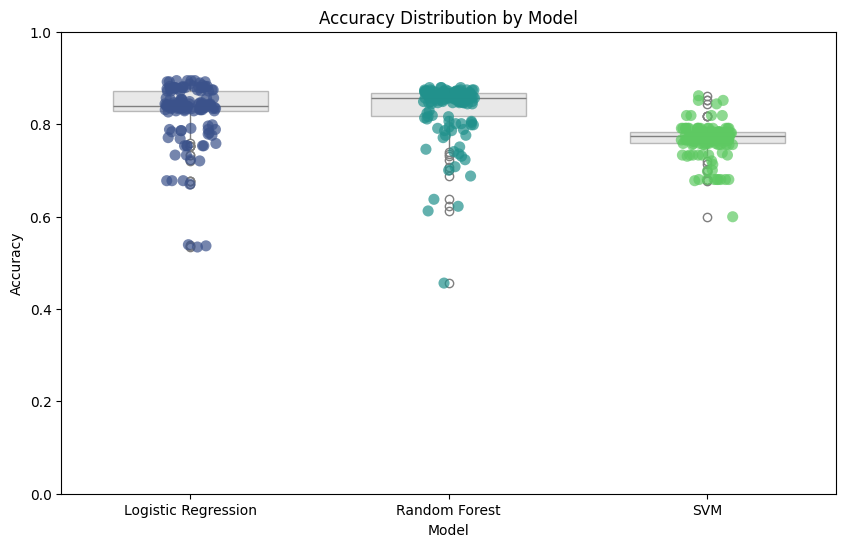

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the CSV file
csv_path = "E:\OneDrive\Desktop\GP\csv\ml_model_results.csv"  # Replace with the actual file path
df = pd.read_csv(csv_path)



plt.figure(figsize=(10, 6))
sns.stripplot(x='model', y='accuracy', data=df, jitter=True, size=8, alpha=0.7, palette='viridis')
sns.boxplot(x='model', y='accuracy', data=df, color='lightgrey', width=0.6, showcaps=False, 
            boxprops={'zorder': -1, 'alpha': 0.5})
plt.title("Accuracy Distribution by Model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.show()
